# Combining Sentiment Analysis and Technical Indicators for Trading Signal Prediction

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

### 20 years of data for 
- NVDA (NVIDIA): High growth and long-term uptrend
- ^GSPC (S&P 500): Benchmark index; standard to measure performance
- KO (Coca-Cola Company): Buy low and sell high more frequently
- XOM (Exxon Mobil Corp): Long-term downtrend; especially during oil crashes

In [2]:
stocks = ['NVDA', '^GSPC', 'KO', 'XOM']
tick = yf.download(stocks, start='2005-01-01', end='2025-08-02', group_by='ticker', auto_adjust=False, multi_level_index=False)
tick.head()

[*********************100%***********************]  4 of 4 completed


Ticker          NVDA                                                      \
Price           Open      High       Low     Close Adj Close      Volume   
Date                                                                       
2005-01-03  0.203167  0.206000  0.195667  0.196500  0.180178  1066716000   
2005-01-04  0.197917  0.198250  0.184250  0.187250  0.171696   790224000   
2005-01-05  0.185250  0.191250  0.184250  0.189000  0.173301   724812000   
2005-01-06  0.192333  0.194583  0.185833  0.187167  0.171620   563568000   
2005-01-07  0.187583  0.189000  0.180833  0.183583  0.168334   763092000   

Ticker             KO                                ...        ^GSPC  \
Price            Open       High        Low   Close  ...          Low   
Date                                                 ...                
2005-01-03  20.950001  20.985001  20.705000  20.770  ...  1200.319946   
2005-01-04  20.770000  20.825001  20.450001  20.480  ...  1185.390015   
2005-01-05  20.500000  20.600000  20.370001  20.385  ...  1183.719971   
2005-01-06  20.344999  20.575001  20.275000  20.555  ...  1183.270020   
2005-01-07  20.535000  20.730000  20.424999  20.580  ...  1182.160034   

Ticker                                                  XOM             \
Price             Close    Adj Close      Volume       Open       High   
Date                                                                     
2005-01-03  1202.079956  1202.079956  1510800000  51.020000  51.020000   
2005-01-04  1188.050049  1188.050049  1721000000  50.340000  50.599998   
2005-01-05  1183.739990  1183.739990  1738900000  49.830002  50.110001   
2005-01-06  1187.890015  1187.890015  1569100000  49.299999  50.189999   
2005-01-07  1186.189941  1186.189941  1477900000  50.119999  50.259998   

Ticker                                                 
Price             Low      Close  Adj Close    Volume  
Date                                                   
2005-01-03  49.869999  50.090000  25.093658  16009200  
2005-01-04  49.680000  49.750000  24.923323  16718000  
2005-01-05  49.450001  49.490002  24.793074  12189100  
2005-01-06  49.250000  50.119999  25.108685  13098700  
2005-01-07  49.520000  49.790001  24.943367  11315300  

[5 rows x 24 columns]

In [3]:
df = tick.xs('Adj Close', axis=1, level=1)
df_o = tick.xs('Open', axis=1, level=1)
df_c = tick.xs('Close', axis=1, level=1)
df_h = tick.xs('High', axis=1, level=1)
df_l = tick.xs('Low', axis=1, level=1)

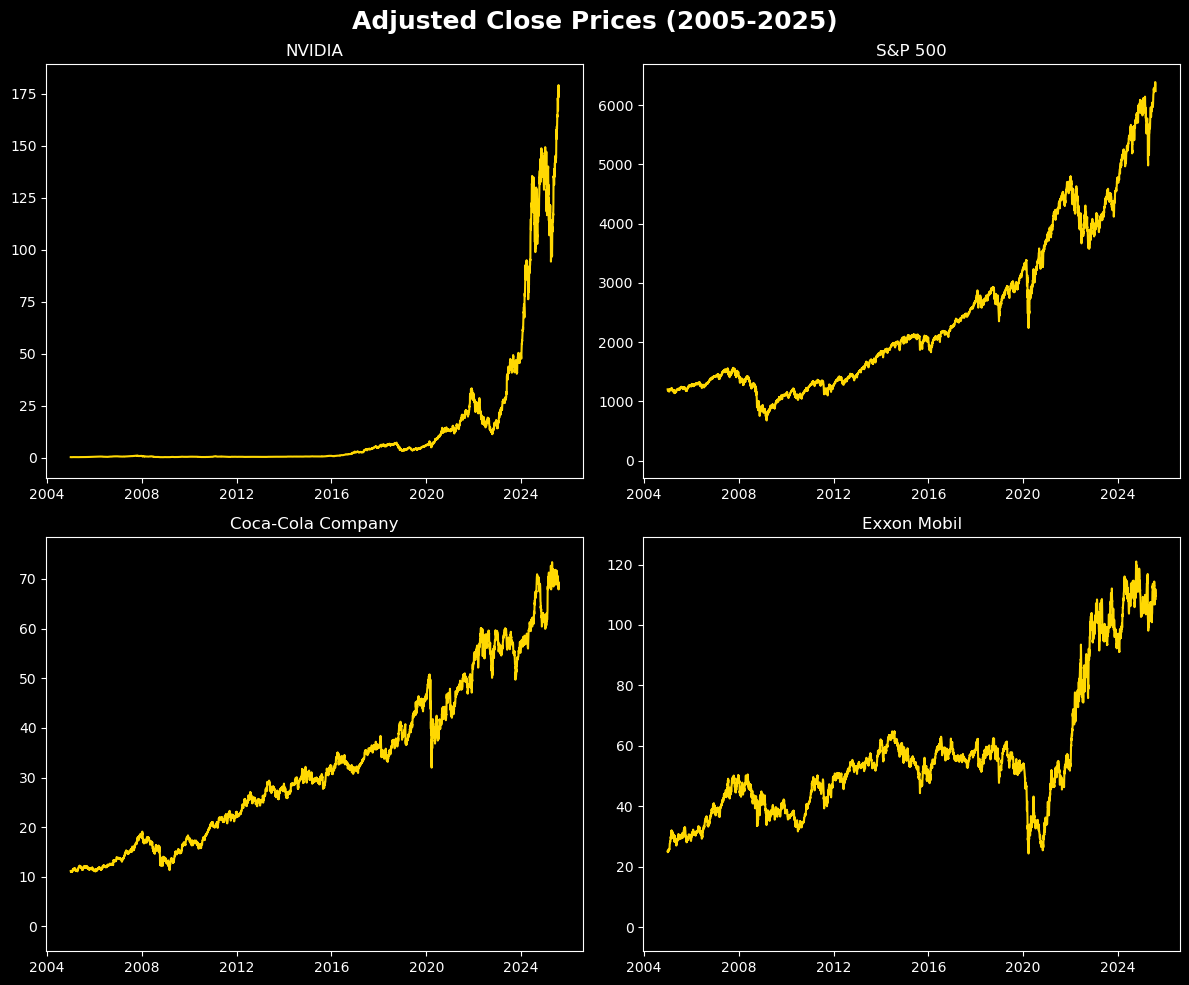

In [11]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(12, 10)
fig.suptitle('Adjusted Close Prices (2005-2025)', fontsize=18, fontweight='bold')
ax[0, 0].set_ylim(-10, df['NVDA'].max()+10)
ax[0, 1].set_ylim(-300, df['^GSPC'].max()+300)
ax[1, 0].set_ylim(-5, df['KO'].max()+5)
ax[1, 1].set_ylim(-8, df['XOM'].max()+8)
ax[0,0].set_title('NVIDIA')
ax[0, 1].set_title('S&P 500')
ax[1, 0].set_title('Coca-Cola Company')
ax[1, 1].set_title('Exxon Mobil')
ax[0, 0].plot(df['NVDA'], color='#FFD802')
ax[0, 1].plot(df['^GSPC'], color='#FFD802')
ax[1, 0].plot(df['KO'], color='#FFD802')
ax[1, 1].plot(df['XOM'], color='#FFD802')
fig.tight_layout()

### Technical indicators:
- Relative strength index (RSI): Measures the velocity and magnitude of price movements. It typically uses a 14-day timeframe, measured on a scale from 0 to 100, with high and low levels marked at 70 and 30, respectively.
- Differential between Open and Close price, and between High and Low price: It captures if there are agressive movements during the day.
- Volatility: Degree of variation of a trading price over 5 days; measured by the standard deviation of logarithmic returns.
- Z-score: Number of standard deviations by which the value of an observed value is above or below the mean value in a 10-day timeframe.
- Momentum: Rate at which a stock's price changes in a 3-day timeframe.

In [4]:
stock_dfs = {}

for stock in df.columns: 
    df_stock = pd.DataFrame()
    df_stock['Close'] = df[stock]  
    df_stock['Open'] = df_o[stock]     
    df_stock['High'] = df_h[stock]      
    df_stock['Low'] = df_l[stock]        
    
    def relative_strength_idx(df, n=14):
        delta = df['Close'].diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(n).mean()
        avg_loss = loss.rolling(n).mean()
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi
    
    df_stock['RSI'] = relative_strength_idx(df_stock).fillna(0)
    
    df_stock['Open-Close'] = df_stock['Open'] - df_stock['Close']
    df_stock['High-Low'] = df_stock['High'] - df_stock['Low']

    df_stock['Log_Return'] = np.log(df_stock['Close'] / df_stock['Close'].shift(1))
    df_stock['Volatility'] = df_stock['Log_Return'].rolling(5).std()
    
    df_stock['volatility_5'] = df_stock['Close'].pct_change().rolling(window=5).std().shift(1)
    
    df_stock['zscore_10'] = (df_stock['Close'] - df_stock['Close'].rolling(10).mean()) / df_stock['Close'].rolling(10).std()
    df_stock['zscore_10'] = df_stock['zscore_10'].shift(1)
    df_stock['momentum_3'] = df_stock['Close'] / df_stock['Close'].shift(3) - 1
    
    stock_dfs[stock] = df_stock

xom_df = stock_dfs['XOM']
sp_df = stock_dfs['^GSPC']
ko_df = stock_dfs['KO']
nvda_df = stock_dfs['NVDA']

### Trying different thresholds to establish in which moment to buy, sell or hold

In [13]:
sp_df['Next_Return'] = sp_df['Close'].shift(-1) / sp_df['Close'] - 1

for thresh in [0.002, 0.003, 0.0035, 0.004, 0.005]:
    sp_df['Target'] = np.select(
        [sp_df['Next_Return'] > thresh, sp_df['Next_Return'] < -thresh],
        [1, 2],
        default=0
    )
    print(f"Threshold: {thresh}")
    print(sp_df['Target'].value_counts(normalize=True))

Threshold: 0.002
Target
1    0.418694
2    0.337775
0    0.243530
Name: proportion, dtype: float64
Threshold: 0.003
Target
1    0.366551
0    0.341058
2    0.292391
Name: proportion, dtype: float64
Threshold: 0.0035
Target
0    0.381035
1    0.346466
2    0.272499
Name: proportion, dtype: float64
Threshold: 0.004
Target
0    0.426033
1    0.320780
2    0.253187
Name: proportion, dtype: float64
Threshold: 0.005
Target
0    0.495558
1    0.279258
2    0.225183
Name: proportion, dtype: float64


### A threshold of 0.3% gives well-balanced classes

In [5]:
buy_thresh = 0.003
sell_thresh = -0.003

for i in stock_dfs:
    stock_dfs[i]['Next_Return'] = stock_dfs[i]['Close'].shift(-1) / stock_dfs[i]['Close'] - 1

    stock_dfs[i]['Signal'] = np.select(
        [stock_dfs[i]['Next_Return'] > buy_thresh,
            stock_dfs[i]['Next_Return'] < sell_thresh],
        [1, 2],
        default=0
    )

    stock_dfs[i]['Close'] = stock_dfs[i]['Close'].shift(-1)
    stock_dfs[i].dropna(inplace=True)

In [ ]:
features = ['Open-Close', 'High-Low', 'RSI', 'Volatility', 'volatility_5', 'zscore_10', 'momentum_3']

In [7]:
def prepare_data(df):
    X = df[features]
    y = df['Signal']
    return X, y

In [ ]:
X, y = prepare_data(ko_df)  ## sp_df, xom_df, nvda_df

### Split train and test set

In [417]:
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

### 3 most used algorithms in finance and stock prediction:
- Random Forest Classifier
- XGBoost
- Balanced Random Forest 

### Grid search for hyperparameters

In [ ]:
param_grid = {
        'n_estimators': [100, 300, 500],
        'max_depth': [2, 3, 5],
        'min_samples_split': [5, 10, 15],
        'class_weight': ['balanced'],
        'random_state': [123],
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, scoring = 'f1_macro', cv=3)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f'RFC Best parameters: {best_params}')

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 3, 5],
    'learning_rate': [0.001, 0.01, 0.1],
    'subsample': [0.8, 1.0],
    'num_class': [3],
    'random_state': [42]
}

grid_search = GridSearchCV(XGBClassifier(), param_grid, scoring = 'f1_macro', cv=3, verbose=1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f'XGB Best parameters: {best_params}')

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 3, 5],
    'ccp_alpha': [0.01, None],
    'bootstrap': [True, False],
    'sampling_strategy': ['all', None],
    'random_state': [42]
}

grid_search = GridSearchCV(BalancedRandomForestClassifier(), param_grid, scoring = 'f1_macro', cv=3)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f'Bal RF Best parameters: {best_params}')

### Pipeline for the 3 models:

In [387]:
# KO
pipelines = {
    "Random_Forest": Pipeline([
        ("model", RandomForestClassifier(n_estimators=500, max_depth=2, min_samples_split=15, class_weight='balanced', random_state=123)) 
    ]),
    "XGBoost": Pipeline([
        ("model", XGBClassifier(learning_rate=0.001, max_depth=2, n_estimators=300, random_state=42, subsample=0.8, num_class=3)) 
    ]),
    "Balanced_RF": Pipeline([
        ("model", BalancedRandomForestClassifier(n_estimators=300, random_state=42, max_depth=2, bootstrap=True, 
                                                 sampling_strategy='all', ccp_alpha=0.01)) 
    ]),
}

In [405]:
# NVDA
pipelines = {
    "Random_Forest": Pipeline([
        ("model", RandomForestClassifier(n_estimators=300, max_depth=5, min_samples_split=5, class_weight='balanced', random_state=123)) 
    ]),
    "XGBoost": Pipeline([
        ("model", XGBClassifier(objective='multi:softprob', learning_rate=0.001, max_depth=5, n_estimators=200, random_state=42, num_class=3)) 
    ]),
    "Balanced_RF": Pipeline([
        ("model", BalancedRandomForestClassifier(random_state=42, max_depth=6, bootstrap=False)) 
    ]),
}

In [418]:
# XOM
pipelines = {
    "Random_Forest": Pipeline([
        ("model", RandomForestClassifier(n_estimators=100, max_depth=4, min_samples_split=15, class_weight='balanced', random_state=123)) 
    ]),
    "XGBoost": Pipeline([
        ("model", XGBClassifier(objective='multi:softprob', learning_rate=0.001, max_depth=4, n_estimators=200, random_state=42, num_class=3)) 
    ]),
    "Balanced_RF": Pipeline([
        ("model", BalancedRandomForestClassifier(n_estimators=200, random_state=42, max_depth=4, bootstrap=True, sampling_strategy='all')) 
    ]),
}

In [413]:
# SP 500
pipelines = {
    "Random_Forest": Pipeline([
        ("model", RandomForestClassifier(n_estimators=100, max_depth=3, class_weight='balanced', random_state=123)) 
    ]),
    "XGBoost": Pipeline([
        ("model", XGBClassifier(objective='multi:softprob', learning_rate=0.001, max_depth=3, n_estimators=200, random_state=42, num_class=3)) 
    ]),
    "Balanced_RF": Pipeline([
        ("model", BalancedRandomForestClassifier(n_estimators=100, random_state=42, max_depth=3, bootstrap=True, 
                                                 sampling_strategy='all', ccp_alpha=0.01)) 
    ]),
}

### Evaluate model

In [419]:
for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)    
    y_train_pred_pip = pipeline.predict(X_train)
    y_test_pred_pip = pipeline.predict(X_test)
    print(f'{name} Train accuracy: {accuracy_score(y_train,y_train_pred_pip)}')
    print(f'{name} Test accuracy: {accuracy_score(y_test,y_test_pred_pip)}')

Random_Forest Train accuracy: 0.4377612633534603
Random_Forest Test accuracy: 0.4146341463414634
XGBoost Train accuracy: 0.46841616349280074
XGBoost Test accuracy: 0.4088269454123113
Balanced_RF Train accuracy: 0.440315838365072
Balanced_RF Test accuracy: 0.40185830429732866


In [175]:
for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    print(f"{name} Classification Report:\n", classification_report(y_test, pipeline.predict(X_test)))

Random_Forest Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.35      0.35       246
           1       0.38      0.58      0.46       322
           2       0.32      0.13      0.18       293

    accuracy                           0.36       861
   macro avg       0.35      0.35      0.33       861
weighted avg       0.35      0.36      0.33       861

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.02      0.03       246
           1       0.37      0.95      0.53       322
           2       0.27      0.02      0.04       293

    accuracy                           0.37       861
   macro avg       0.35      0.33      0.20       861
weighted avg       0.34      0.37      0.22       861

Balanced_RF Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.42      0.37       246
           1       0.37

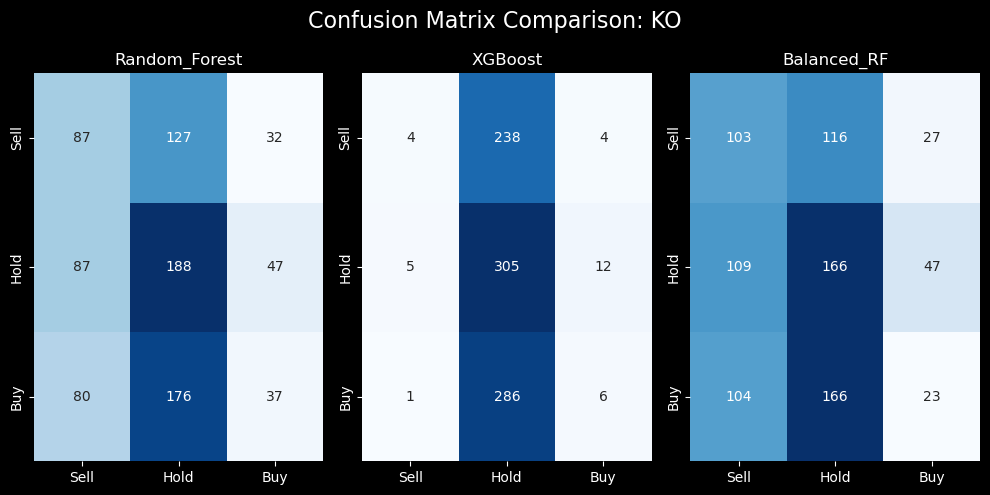

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

for ax, (name, pipeline) in zip(axes, pipelines.items()):
    cm = confusion_matrix(y_test, pipeline.predict(X_test))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Sell', 'Hold', 'Buy'], 
                yticklabels=['Sell', 'Hold', 'Buy'], ax=ax)
    ax.set_title(f'{name}')

plt.suptitle('Confusion Matrix Comparison', fontsize=16)
plt.tight_layout()
plt.show()


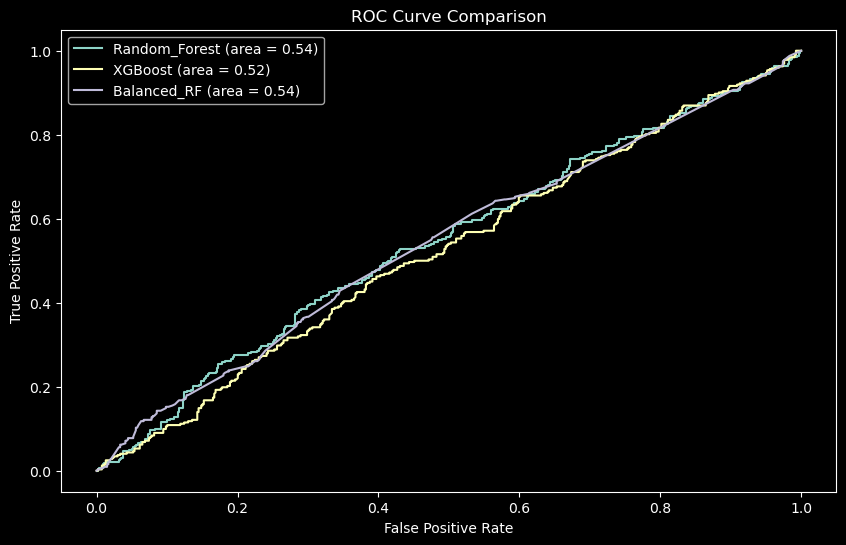

In [13]:
plt.figure(figsize=(10, 6))
for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    fpr, tpr, thresholds = roc_curve(y_test, pipeline.predict_proba(X_test)[:, 1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()

In [ ]:
# def run_strategy1(df, pipelines, X):
#     df['Return'] = df['Close'].pct_change()
#     df['Cum_Ret'] = df['Return'].cumsum()

#     for name, pipeline in pipelines.items():
#         df[f'Predicted_Signal_{name}'] = pipeline.predict(X)
#         df[f'Strategy_Return_{name}'] = df['Return'] * df[f'Predicted_Signal_{name}'].shift(1)
#         df[f'Cumulative_Strategy_Return_{name}'] = df[f'Strategy_Return_{name}'].cumsum()
    
#     return df

In [ ]:
# def plot_returns1(df, pipelines):
#     plt.figure(figsize=(10, 6))
#     plt.plot(df['Cum_Ret'], label='Cumulative Return')
#     for name, pipeline in pipelines.items():
#         plt.plot(df[f'Cumulative_Strategy_Return_{name}'], label=f'{name} Strategy Return')

#     plt.title('Strategy Returns Comparison: KO')
#     plt.legend()

### Checking returns for each model

In [ ]:
def run_strategy(df, pipelines, X):
    df = df.copy()
    df['Return'] = df['Close'].pct_change()
    df['Cum_Stock'] = (1 + df['Return']).cumprod()

    for name, pipeline in pipelines.items():
        df[f'Predicted_Signal_{name}'] = pipeline.predict(X)
        df[f'Shifted_Signal_{name}'] = df[f'Predicted_Signal_{name}'].shift(1)

        def strat(row):
            if row[f'Shifted_Signal_{name}'] == 1:  
                return row['Return']
            elif row[f'Shifted_Signal_{name}'] == 2: 
                return -row['Return']
            else:                                    
                return 0

        df[f'Strategy_Return_{name}'] = df.apply(strat, axis=1)
        df[f'Cum_Strategy_{name}'] = (1 + df[f'Strategy_Return_{name}']).cumprod()

    return df

In [ ]:
def plot_returns(df, pipelines):
    plt.figure(figsize=(10, 6))
    plt.plot(df['Cum_Stock'], label='Cumulative Return')
    for name, pipeline in pipelines.items():
        plt.plot(df[f'Cum_Strategy_{name}'], label=f'{name} Strategy Return')

    plt.title('Strategy Returns Comparison')
    plt.legend()

### Cumulative returns plots for each model

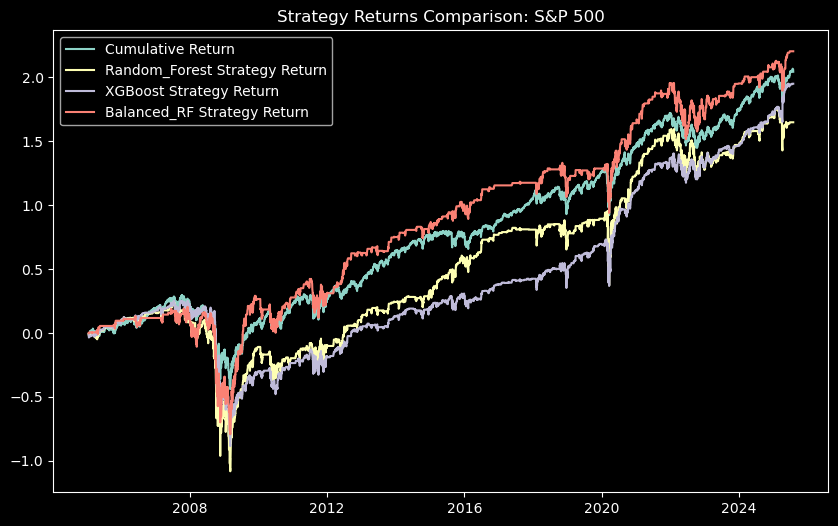

In [139]:
strat_ret_sp = run_strategy(sp_df.copy(), pipelines, X)
plot_returns(strat_ret_sp, pipelines)

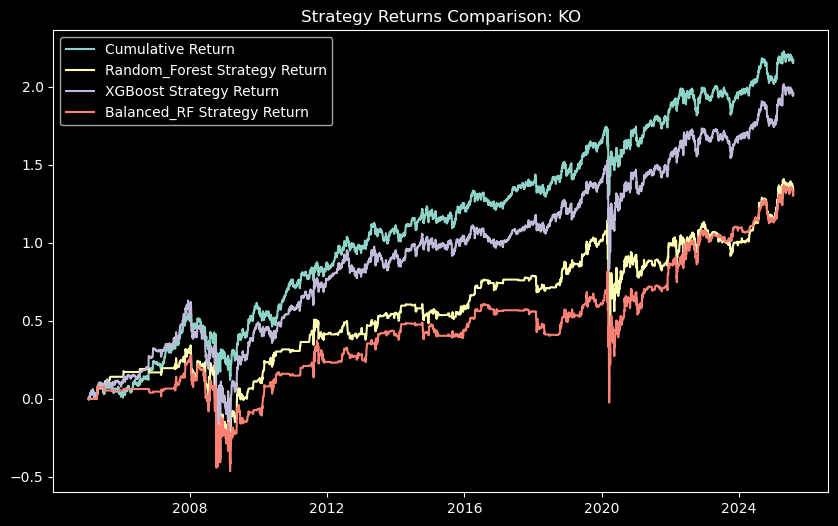

In [16]:
strat_ret_ko = run_strategy(ko_df.copy(), pipelines, X)
plot_returns(strat_ret_ko, pipelines)

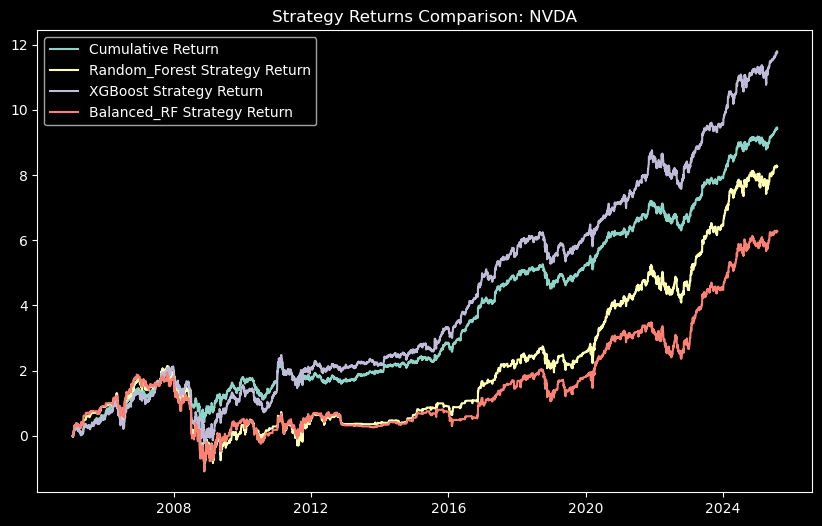

In [40]:
strat_ret_nv = run_strategy(nvda_df.copy(), pipelines, X)
plot_returns(strat_ret_nv, pipelines)

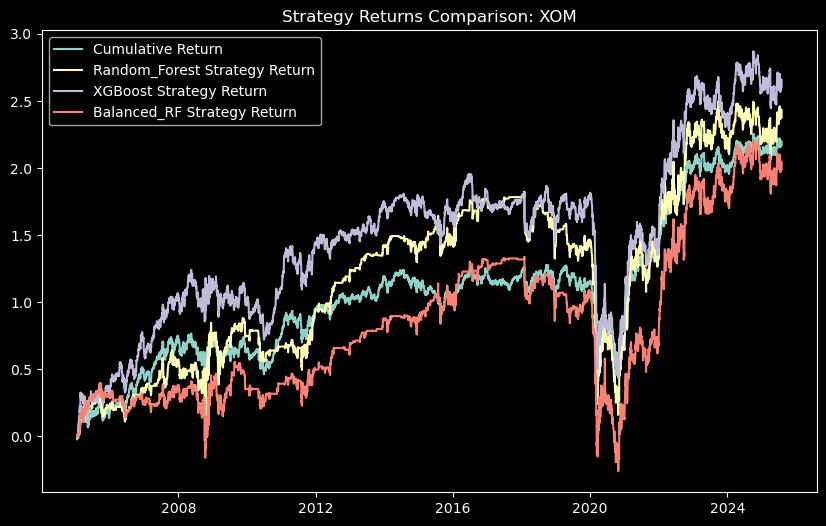

In [80]:
strat_ret_xom = run_strategy(xom_df.copy(), pipelines, X)
plot_returns(strat_ret_xom, pipelines)

### Cumulative returns since January 2024

In [ ]:
# Returns for S&P 500
last_year = strat_ret_sp.iloc[-396:]
stock_return_pct = (last_year['Close'].iloc[-1] / last_year['Close'].iloc[0] - 1) * 100
print(f"Stock return last year: {stock_return_pct:.2f}%")

for name, pipeline in pipelines.items():
    print(f"{name} Strategy Return last year: {((last_year[f'Strategy_Return_{name}'] + 1).prod() - 1) * 100:.2f}%")

Stock return last year: 12.96%
Random_Forest Strategy Return last year: 4.75%
XGBoost Strategy Return last year: 36.35%
Balanced_RF Strategy Return last year: 20.71%


In [ ]:
# Returns for KO
last_year = strat_ret_ko.iloc[-396:] 
stock_return_pct = (last_year['Close'].iloc[-1] / last_year['Close'].iloc[0] - 1) * 100
print(f"Stock return last year: {stock_return_pct:.2f}%")

for name, pipeline in pipelines.items():
    print(f"{name} Strategy Return last year: {((last_year[f'Strategy_Return_{name}'] + 1).prod() - 1) * 100:.2f}%")

Stock return last year: 20.07%
Random_Forest Strategy Return last year: 36.70%
XGBoost Strategy Return last year: 29.19%
Balanced_RF Strategy Return last year: 22.13%


In [ ]:
# Returns for NVDA
last_year = strat_ret_nv.iloc[-396:]
stock_return_pct = (last_year['Close'].iloc[-1] / last_year['Close'].iloc[0] - 1) * 100
print(f"Stock return last year: {stock_return_pct:.2f}%")

for name, pipeline in pipelines.items():
    print(f"{name} Strategy Return last year: {((last_year[f'Strategy_Return_{name}'] + 1).prod() - 1) * 100:.2f}%")

Stock return last year: 265.36%
Random_Forest Strategy Return last year: 241.67%
XGBoost Strategy Return last year: 435.17%
Balanced_RF Strategy Return last year: 295.44%


In [ ]:
# Returns for XOM
last_year = strat_ret_xom.iloc[-396:]
stock_return_pct = (last_year['Close'].iloc[-1] / last_year['Close'].iloc[0] - 1) * 100
print(f"Stock return last year: {stock_return_pct:.2f}%")

for name, pipeline in pipelines.items():
    print(f"{name} Strategy Return last year: {((last_year[f'Strategy_Return_{name}'] + 1).prod() - 1) * 100:.2f}%")

Stock return last year: 11.85%
Random_Forest Strategy Return last year: 4.42%
XGBoost Strategy Return last year: 7.19%
Balanced_RF Strategy Return last year: 4.13%


In [183]:
for name, pipeline in pipelines.items():
    print(f"{strat_ret_ko[f'Predicted_Signal_{name}'].value_counts(normalize=True)}")

Predicted_Signal_Random_Forest
0    0.577705
1    0.290691
2    0.131604
Name: proportion, dtype: float64
Predicted_Signal_XGBoost
1    0.816722
0    0.119799
2    0.063480
Name: proportion, dtype: float64
Predicted_Signal_Balanced_RF
0    0.618347
1    0.234178
2    0.147474
Name: proportion, dtype: float64


In [43]:
for name, pipeline in pipelines.items():
    print(f"{strat_ret_nv[f'Predicted_Signal_{name}'].value_counts(normalize=True)}")

Predicted_Signal_Random_Forest
0    0.374492
1    0.329398
2    0.296110
Name: proportion, dtype: float64
Predicted_Signal_XGBoost
1    0.715115
2    0.272111
0    0.012773
Name: proportion, dtype: float64
Predicted_Signal_Balanced_RF
0    0.385717
1    0.327850
2    0.286433
Name: proportion, dtype: float64


In [81]:
for name, pipeline in pipelines.items():
    print(f"{strat_ret_xom[f'Predicted_Signal_{name}'].value_counts(normalize=True)}")

Predicted_Signal_Random_Forest
0    0.372944
2    0.321657
1    0.305400
Name: proportion, dtype: float64
Predicted_Signal_XGBoost
1    0.583898
2    0.395007
0    0.021095
Name: proportion, dtype: float64
Predicted_Signal_Balanced_RF
0    0.367718
1    0.324173
2    0.308109
Name: proportion, dtype: float64


In [168]:
for name, pipeline in pipelines.items():
    print(f"{strat_ret_sp[f'Predicted_Signal_{name}'].value_counts(normalize=True)}")

Predicted_Signal_Random_Forest
0    0.492742
1    0.319528
2    0.187730
Name: proportion, dtype: float64
Predicted_Signal_XGBoost
0    0.480937
1    0.450165
2    0.068899
Name: proportion, dtype: float64
Predicted_Signal_Balanced_RF
0    0.553706
2    0.246952
1    0.199342
Name: proportion, dtype: float64


### Sharpe Ratio

In [33]:
def sharpe_ratio(returns, risk_free_rate=0.0):
    excess_returns = returns - risk_free_rate
    return np.mean(excess_returns) / np.std(excess_returns)

In [ ]:
# SP 500
print(f"Stock Sharpe Ratio: {sharpe_ratio(last_year['Return'].dropna())}")
for name, pipeline in pipelines.items():
    print(f"{name} Sharpe Ratio: {sharpe_ratio(last_year[f'Strategy_Return_{name}'].dropna())}")

Stock Sharpe Ratio: 0.05041086807620761
Random_Forest Sharpe Ratio: 0.01900477535507827
XGBoost Sharpe Ratio: 0.0891607752984537
Balanced_RF Sharpe Ratio: 0.05537023163714434


In [184]:
# KO
print(f"Stock Sharpe Ratio: {sharpe_ratio(last_year['Return'].dropna())}")
for name, pipeline in pipelines.items():
    print(f"{name} Sharpe Ratio: {sharpe_ratio(last_year[f'Strategy_Return_{name}'].dropna())}")

Stock Sharpe Ratio: 0.05299143526056707
Random_Forest Sharpe Ratio: 0.07832516250249053
XGBoost Sharpe Ratio: 0.06831239743004178
Balanced_RF Sharpe Ratio: 0.058479645539899094


In [45]:
# NVDA
print(f"Stock Sharpe Ratio: {sharpe_ratio(last_year['Return'].dropna())}")
for name, pipeline in pipelines.items():
    print(f"{name} Sharpe Ratio: {sharpe_ratio(last_year[f'Strategy_Return_{name}'].dropna())}")

Stock Sharpe Ratio: 0.11134596160030877
Random_Forest Sharpe Ratio: 0.08500553238270445
XGBoost Sharpe Ratio: 0.10668691136709675
Balanced_RF Sharpe Ratio: 0.09909617140660605


In [82]:
# XOM
print(f"Stock Sharpe Ratio: {sharpe_ratio(last_year['Return'].dropna())}")
for name, pipeline in pipelines.items():
    print(f"{name} Sharpe Ratio: {sharpe_ratio(last_year[f'Strategy_Return_{name}'].dropna())}")

Stock Sharpe Ratio: 0.02877215499444199
Random_Forest Sharpe Ratio: 0.01713766245726478
XGBoost Sharpe Ratio: 0.02001515439845102
Balanced_RF Sharpe Ratio: 0.01718954759302591


## Sentiment Analysis

With Finnhub API free tier we can have access to headline news only for the last year. Since Coca-Cola Company (KO) was the only stock were either model couldn't outperform the stock returns, we are using KO headlines to implement sentiment analysis in the XGBoost model since it was the closest to the stock return.

In [ ]:
news_df = pd.read_csv("finnhub_news_ko.csv") # Already downloaded with finnhub_scrape.py
news_df["date"] = pd.to_datetime(news_df["date"], format='%d/%m/%Y')

In [19]:
news_df

,date,headline,url
0,2024-09-02,Tracking Ray Dalio's Bridgewater Associates 13...,https://finnhub.io/api/news?id=75fd8d4b044936c...
1,2024-09-02,Columbia Dividend Opportunity Fund Q2 2024 Inv...,https://finnhub.io/api/news?id=aa3cc09df2b4f65...
2,2024-09-02,Coca-Cola stock trades in the green for seven ...,https://finnhub.io/api/news?id=e536f98e7d1a251...
3,2024-09-03,"Nielsen reads: Bang, Keurig Dr Pepper and Cons...",https://finnhub.io/api/news?id=ffbc9c8a6d3ee9b...
4,2024-09-03,How Much Will Coca-Cola Pay Out in Dividends T...,https://finnhub.io/api/news?id=a1d2fd234ceabe7...
...,...,...,...
1956,2025-08-01,2 Magnificent Dividend Stocks to Buy in August,https://finnhub.io/api/news?id=f5a9cbfb3ef6de5...
1957,2025-08-01,"How to Buy KO for a 2% Discount, or Achieve a ...",https://finnhub.io/api/news?id=fd8b2e72046bbe0...
1958,2025-08-02,1 Warren Buffett Stock to Buy Hand Over Fist a...,https://finnhub.io/api/news?id=b0720ee2c7ac1c1...
1959,2025-08-03,Warren Buffett's Advice: 'If You Aren't Willin...,https://finnhub.io/api/news?id=bd45ed7c0763861...


### Pretrained model Finbert

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, pipeline

tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert")
model = BertForSequenceClassification.from_pretrained("ProsusAI/finbert")
finbert = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

Device set to use cpu


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

c:\Users\luisr\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\luisr\.cache\huggingface\hub\models--ProsusAI--finbert. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [ ]:
from tqdm import tqdm

sentiments = []
scores = []

for headline in tqdm(news_df["headline"]):
    result = finbert(headline)[0]
    sentiments.append(result['label'])
    scores.append(result['score'])

news_df["sentiment"] = sentiments
news_df["score"] = scores


100%|██████████| 1961/1961 [02:07<00:00, 15.35it/s]


### Saved in file so we don't have to run finbert again

In [8]:
news_df = pd.read_csv("finnhub_news_ko_sentiment.csv")

In [9]:
news_df

,date,headline,url,sentiment,score
0,2024-09-02,Tracking Ray Dalio's Bridgewater Associates 13...,https://finnhub.io/api/news?id=75fd8d4b044936c...,neutral,0.943794
1,2024-09-02,Columbia Dividend Opportunity Fund Q2 2024 Inv...,https://finnhub.io/api/news?id=aa3cc09df2b4f65...,neutral,0.914378
2,2024-09-02,Coca-Cola stock trades in the green for seven ...,https://finnhub.io/api/news?id=e536f98e7d1a251...,neutral,0.621185
3,2024-09-03,"Nielsen reads: Bang, Keurig Dr Pepper and Cons...",https://finnhub.io/api/news?id=ffbc9c8a6d3ee9b...,positive,0.532090
4,2024-09-03,How Much Will Coca-Cola Pay Out in Dividends T...,https://finnhub.io/api/news?id=a1d2fd234ceabe7...,neutral,0.941573
...,...,...,...,...,...
1956,2025-08-01,2 Magnificent Dividend Stocks to Buy in August,https://finnhub.io/api/news?id=f5a9cbfb3ef6de5...,neutral,0.917370
1957,2025-08-01,"How to Buy KO for a 2% Discount, or Achieve a ...",https://finnhub.io/api/news?id=fd8b2e72046bbe0...,neutral,0.900990
1958,2025-08-02,1 Warren Buffett Stock to Buy Hand Over Fist a...,https://finnhub.io/api/news?id=b0720ee2c7ac1c1...,neutral,0.927046
1959,2025-08-03,Warren Buffett's Advice: 'If You Aren't Willin...,https://finnhub.io/api/news?id=bd45ed7c0763861...,neutral,0.903296


In [10]:
news_df['sent'] = news_df['sentiment'].replace({'negative': -1, 'neutral': 0, 'positive': 1})
daily_sentiment = news_df.groupby("date")["sent"].mean().reset_index()
daily_sentiment["date"] = pd.to_datetime(daily_sentiment["date"], format='%Y-%m-%d')

C:\Users\luisr\AppData\Local\Temp\ipykernel_12276\2744130938.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  news_df['sent'] = news_df['sentiment'].replace({'negative': -1, 'neutral': 0, 'positive': 1})


In [11]:
daily_sentiment

,date,sent
0,2024-09-02,0.000000
1,2024-09-03,0.375000
2,2024-09-04,-0.125000
3,2024-09-05,-0.083333
4,2024-09-06,-0.200000
...,...,...
309,2025-07-30,0.000000
310,2025-07-31,0.153846
311,2025-08-01,0.000000
312,2025-08-02,0.000000


### Train full model on the 20 years and fine-tune with sentiment only for the last year

In [12]:
df_merged = ko_df.merge(daily_sentiment, left_on='Date', right_on="date", how="left")

In [13]:
df_merged['sent'] = df_merged['sent'].fillna(0)

### Model with sentiment score

In [15]:
df_merged['sent_lag1'] = df_merged['sent'].shift(1)

In [16]:
features_sent = ['RSI', 'volatility_5', 'zscore_10', 'momentum_3',
                 'Open-Close', 'High-Low', 'Volatility', 'sent_lag1']

X_sent = df_merged[features_sent]
y = df_merged['Signal']

model_sent = XGBClassifier(learning_rate=0.0001, max_depth=2, n_estimators=300, random_state=42, num_class=3)
model_sent.fit(X_sent, y)

df_last_year = df_merged[df_merged['date'] >= '2024-09-03'].copy()

X_test_sent = df_last_year[features_sent]
y_test_sent = df_last_year['Signal']
df_last_year['Pred_Signal_sent'] = model_sent.predict(X_test_sent)

In [17]:
y_train_pred_pip = model_sent.predict(X_sent)
y_test_pred_pip = model_sent.predict(X_test_sent)
print(f'Train accuracy: {accuracy_score(y,y_train_pred_pip)}')
print(f'Test accuracy: {accuracy_score(y_test_sent,y_test_pred_pip)}')

Train accuracy: 0.4013934584865493
Test accuracy: 0.3918918918918919


In [18]:
preds = model_sent.predict(X_test_sent)
print(classification_report(y_test_sent, preds))

              precision    recall  f1-score   support

           0       1.00      0.02      0.04        54
           1       0.35      0.75      0.48        77
           2       0.52      0.31      0.39        91

    accuracy                           0.39       222
   macro avg       0.62      0.36      0.30       222
weighted avg       0.58      0.39      0.33       222



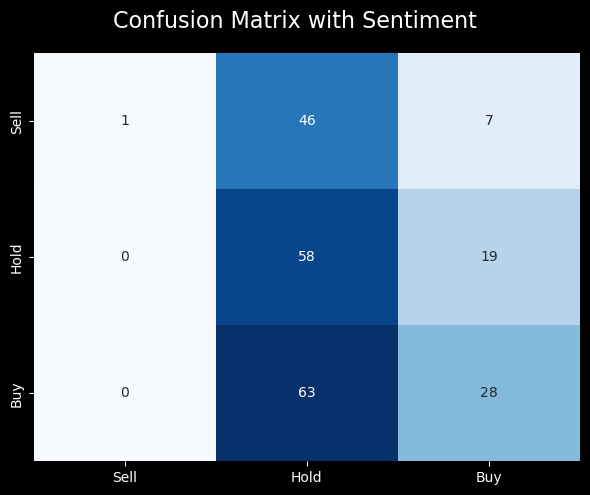

In [20]:
fig, ax = plt.subplots(figsize=(6, 5))
cm = confusion_matrix(y_test_sent, model_sent.predict(X_test_sent))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sell', 'Hold', 'Buy'], 
            yticklabels=['Sell', 'Hold', 'Buy'], ax=ax)
plt.suptitle('Confusion Matrix with Sentiment', fontsize=16)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'ROC Curve with Sentiment')

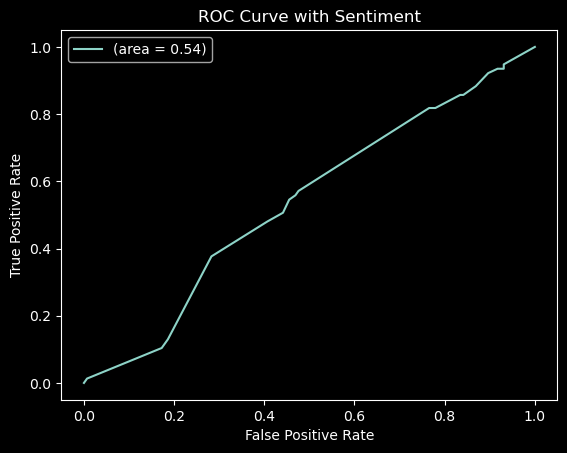

In [22]:
fpr, tpr, thresholds = roc_curve(y_test_sent, model_sent.predict_proba(X_test_sent)[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'(area = {roc_auc:.2f})')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Sentiment')

### Model without sentiment score

In [23]:
features_nosent = ['RSI', 'volatility_5', 'zscore_10', 'momentum_3',
                   'Open-Close', 'High-Low', 'Volatility']

X_nosent = df_merged[features_nosent]
model_nosent = XGBClassifier(learning_rate=0.0001, max_depth=2, n_estimators=300, random_state=42, num_class=3)
model_nosent.fit(X_nosent, y)

X_test_nosent = df_last_year[features_nosent]
y_test_nosent = df_last_year['Signal']
df_last_year['Pred_Signal_nosent'] = model_nosent.predict(X_test_nosent)

In [24]:
y_train_pred_pip = model_nosent.predict(X_nosent)
y_test_pred_pip = model_nosent.predict(X_test_nosent)
print(f'Train accuracy: {accuracy_score(y,y_train_pred_pip)}')
print(f'Test accuracy: {accuracy_score(y_test_nosent,y_test_pred_pip)}')

Train accuracy: 0.40449003290110314
Test accuracy: 0.36936936936936937


In [25]:
preds = model_nosent.predict(X_test_nosent)
print(classification_report(y_test_nosent, preds))

              precision    recall  f1-score   support

           0       1.00      0.02      0.04        54
           1       0.34      0.78      0.48        77
           2       0.46      0.23      0.31        91

    accuracy                           0.37       222
   macro avg       0.60      0.34      0.27       222
weighted avg       0.55      0.37      0.30       222



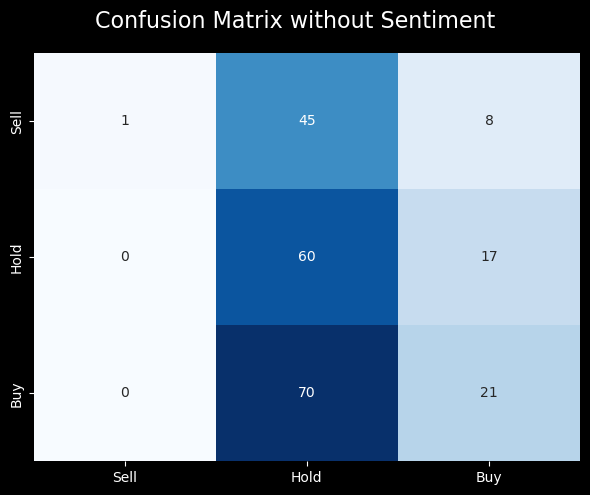

In [26]:
fig, ax = plt.subplots(figsize=(6, 5))
cm = confusion_matrix(y_test_nosent, model_nosent.predict(X_test_nosent))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sell', 'Hold', 'Buy'], 
            yticklabels=['Sell', 'Hold', 'Buy'], ax=ax)
plt.suptitle('Confusion Matrix without Sentiment', fontsize=16)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'ROC Curve without Sentiment')

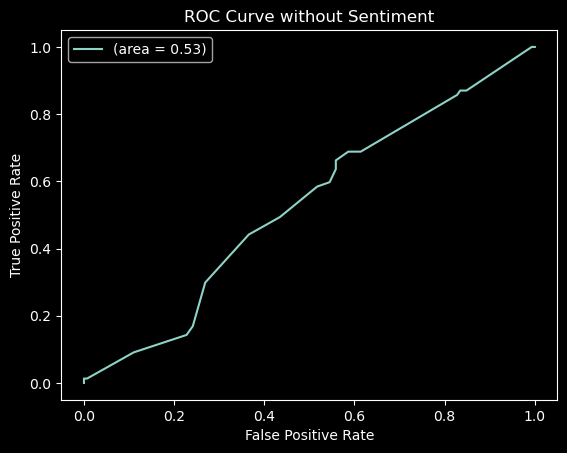

In [27]:
fpr, tpr, thresholds = roc_curve(y_test_nosent, model_nosent.predict_proba(X_test_nosent)[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'(area = {roc_auc:.2f})')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve without Sentiment')

### Backtest and returns

In [28]:
def backtest_series(df, signal_col):
    df = df.copy()
    df['Return'] = df['Close'].pct_change()

    def strat(row):
        if row[signal_col] == 1: return row['Return']
        elif row[signal_col] == 2: return -row['Return']
        else: return 0

    df['Strategy_Return'] = df.apply(strat, axis=1)

    df['Cum_Stock'] = (1 + df['Return']).cumprod()
    df['Cum_Strategy'] = (1 + df['Strategy_Return']).cumprod()
    return df[['date', 'Cum_Stock', 'Cum_Strategy']]

In [29]:
results_sent = backtest_series(df_last_year, 'Pred_Signal_sent')
results_nosent = backtest_series(df_last_year, 'Pred_Signal_nosent')
results_sent = results_sent.rename(columns={'Cum_Strategy': 'Cum_Strategy_sent'})
results_nosent = results_nosent.rename(columns={'Cum_Strategy': 'Cum_Strategy_nosent'})
results = results_sent.merge(results_nosent[['date', 'Cum_Strategy_nosent']], on='date')

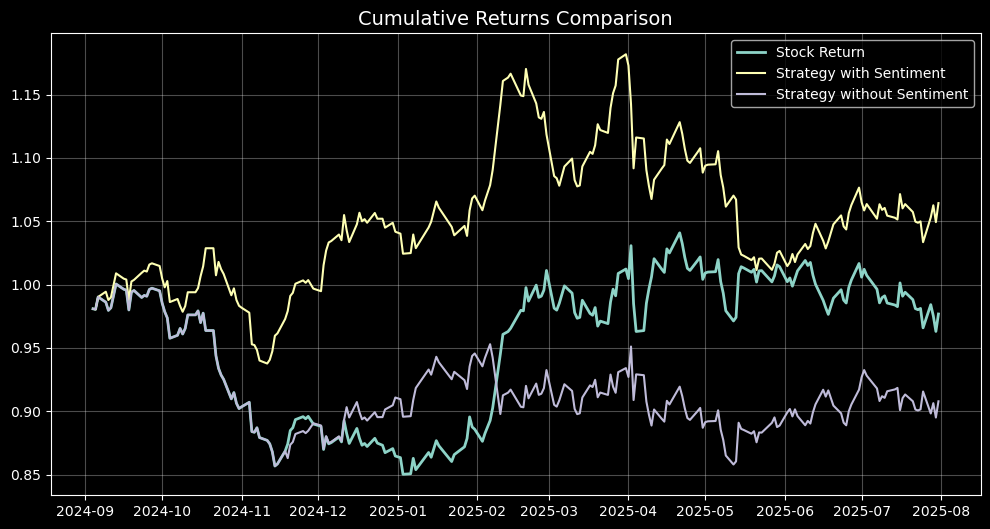

In [37]:
plt.figure(figsize=(12,6))
plt.plot(results['date'], results['Cum_Stock'], label='Stock Return', linewidth=2)
plt.plot(results['date'], results['Cum_Strategy_sent'], label='Strategy with Sentiment')
plt.plot(results['date'], results['Cum_Strategy_nosent'], label='Strategy without Sentiment')

plt.title("Cumulative Returns Comparison", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
print(f"Stock return: {results['Cum_Stock'].iloc[-1] - 1:.2%}")
print(f"Strategy with sentiment: {results['Cum_Strategy_sent'].iloc[-1] - 1:.2%}")
print(f"Strategy without sentiment: {results['Cum_Strategy_nosent'].iloc[-1] - 1:.2%}")

Stock return: -2.32%
Strategy with sentiment: 6.43%
Strategy without sentiment: -9.22%


### Sentiment information improved strategy performance